### Introduction

I have chosen to do this assignment with my personal Toggl Track archive. Toggl is a time-tracking application that records time entries whenever a timer is manually started and stopped. Each entry corresponds to a logged work session and can be labeled with projects, task descriptions, and tags.

I began using Toggl at around the start of my sophomore year (October 2024). At the time, my motivation was practical, I wanted to understand how much time I was actually spending on assignments and pre-class work in order to manage my workload more intentionally. Like most Minervans, I felt busy, but I didn’t have a quantitative understanding of where my time was going.

Very quickly, the Toggl became more than a temporary measurement device. I noticed that I worked more efficiently when the stopwatch was running. The act of tracking introduced a mild accountability mechanism, where I felt like if the timer was on, the time needed to “mean something.” In that sense, the data is not just a passive record of behavior, but partially shaped by the act of measurement itself. Turning on the timer became a ritual for “locking in,” and over time it has become second nature, especially when beginning focused work or tracking hours for contracting roles.

Each row in this dataset represents a discrete focus block — a period of intentional, uninterrupted work. When I leave my laptop, get distracted, or shift context, I pause the timer. Because of this, I believe the durations recorded are fairly representative of true focused work time rather than ambient laptop time. The dataset therefore approximates my ability to sustain attention across different projects, times of day, and motivational states.

Up to this point, I have only looked at daily and weekly summaries to estimate workload (and ability to focus). I have never modeled the data. This project is therefore my first attempt to treat my own time as something that can be analyzed, characterized, and potentially predicted. The central question motivating this assignment is “Can I predict how much time I will spend on a particular task at a particular time of day?” If possible, such a model could serve as a realistic proxy for expected focus capacity. Instead of assuming, out of sheer willpower, that a task “should” fit into a certain time block, I could use historical behavioral data to estimate what is actually likely.

### The Data

The dataset was exported directly from Toggl using the built-in export feature. It contains 1,340 recorded work sessions between October 1, 2024 and February 15, 2026. Each row represents one recorded time entry (a focus block).

The raw export includes the following fields:

- Description (string, free-text task label)
- Billable (binary, whether the session was marked as billable work)
- Duration (stored in HH:MM:SS format)
- Member and Email (string, account data)
- Project (string, primary grouping category — only one per time block)
- Tags (string(s), optional secondary labels — multiple possible per time block)
- Start date and start time (in YYYY-MM-DD and HH:MM:SS format respectively)
- Stop date and stop time  (in YYYY-MM-DD and HH:MM:SS format respectively)

Structurally, the dataset is event-based: each row captures the beginning and end of a single tracked session. Before modeling, I will need to convert duration from HH:MM:SS into a continuous numerical variable (probably total minutes). The start and stop timestamps will also need to be combined into a single datetime object to derive features like hour of day, weekday, or period of the year.

Because this dataset reflects how I personally organized my things on Toggl, some preprocessing requires me to fix my own inconsistencies. For example, I currently have a project titled “work” where I track time spent at jobs or internships. However, before creating that unified project, I stored work hours under individual project names such as “surfwisely.” From a modeling perspective, these should be consolidated under the single “work” category to prevent artificial fragmentation of the label space.

There are also fields that are present in the export but not meaningfully used by me as a user. Variables such as Billable, Member, Email, and Tags do not contain useful signal for this particular modeling goal (because I don’t use those features) and can reasonably be removed during preprocessing.

This dataset spans multiple semesters, jobs, shifts in academic intensity, and changes in routine. It only captures time I’d consider focused productivity which does not include class time, park-walk brainstorm sessions, or moments where I was “half working” (for example, doing pre-class work on the bus). In that sense, it isn’t and shouldn’t be treated as a record of total cognitive labor, but a record of deliberate locked-in focus.

In [2]:
'''LOADING DATA INTO PYTHON'''

import pandas as pd

# Load data into pandas
csv_path = 'TogglTrack_Report_Detailed_report_(from_10_01_2024_to_02_15_2026).csv'
df = pd.read_csv(csv_path)

# Replace '-' in certain columns to be null
for col in ['Description', 'Project', 'Tags']:
    if col in df.columns:
        df[col] = df[col].replace('-', pd.NA)


Rows (raw): 1340
Average session length: 46.44 minutes
Median session length: 37.69 minutes
Duration skewness: 5.75
99th percentile: 162.44 minutes


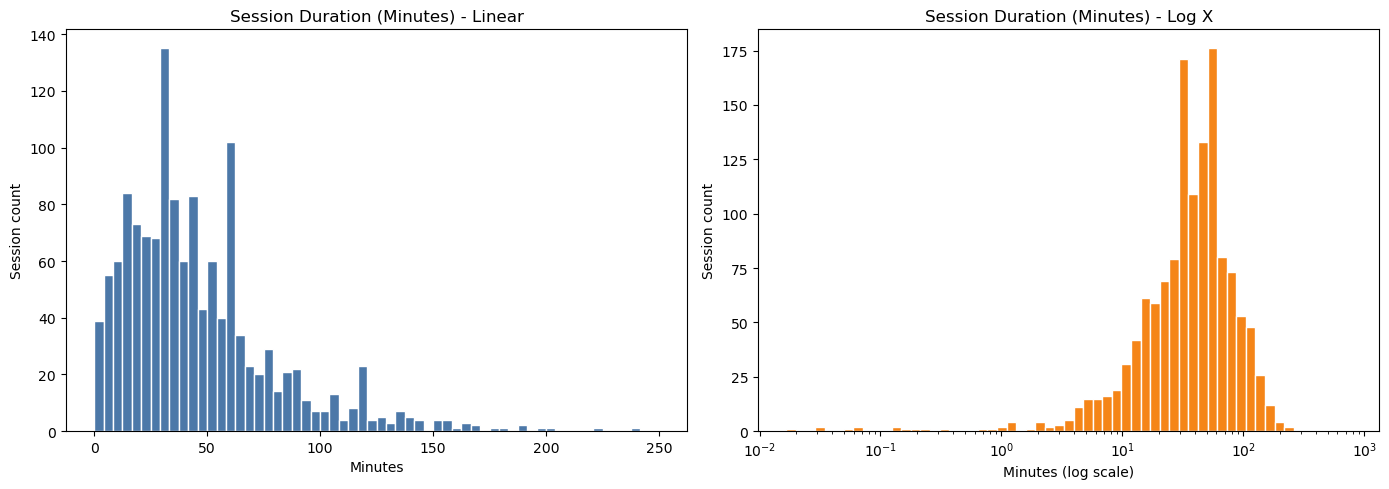

In [5]:
'''BASIC SUMMARY STATS OF DATA'''

import numpy as np
import matplotlib.pyplot as plt

# Creates a new column in the dataframe converting the HH:MM:SS duration data into seconds
df['duration_seconds'] = pd.to_timedelta(df['Duration'], errors='coerce').dt.total_seconds()

# Basic stats
raw_count = len(df)
mean_min = df['duration_seconds'].mean() / 60       # Converts the duration (in seconds) to minutes
median_min = df['duration_seconds'].median() / 60
skewness = df['duration_seconds'].skew()
p99_min = df['duration_seconds'].quantile(0.99) / 60

print(f'Rows (raw): {raw_count}')
print(f'Average session length: {mean_min:.2f} minutes')
print(f'Median session length: {median_min:.2f} minutes')
print(f'Duration skewness: {skewness:.2f}')
print(f'99th percentile: {p99_min:.2f} minutes')

# Skew visualizations
dur_min = df['duration_seconds'] / 60 # duration in minutes
positive = dur_min[dur_min > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear histogram
axes[0].hist(positive, bins=60, range=(0,250), color='#4C78A8', edgecolor='white')
axes[0].set_title('Session Duration (Minutes) - Linear')
axes[0].set_xlabel('Minutes')
axes[0].set_ylabel('Session count')

# Log-scale x-axis histogram
log_bins = np.logspace(np.log10(positive.min()), np.log10(positive.max()), 60)
axes[1].hist(positive, bins=log_bins, color='#F58518', edgecolor='white')
axes[1].set_xscale('log')
axes[1].set_title('Session Duration (Minutes) - Log X')
axes[1].set_xlabel('Minutes (log scale)')
axes[1].set_ylabel('Session count')

plt.tight_layout()
plt.show()



I decided to first understand what my focus behavior actually looks like numerically as I thought it would help me decide how I should approach building my model.

From the histogram on the linear scale, we can see that my focus time is pretty right-skewed. This means most of my sessions cluster under an hour, but there’s a long tail of much longer focus blocks. The 99th percentile is 162.44 minutes — which honestly I’m pretty surprised by — so most sessions are moderate in length but there are a few really long sessions that create that long tail.

A skewed distribution is difficult to model so I also plotted the data on a log scale. After plotting the distribution became much more balanced and interpretable, so a transformation may be necessary for modeling.